<a href="https://colab.research.google.com/github/fernandofsilva/thesis/blob/main/Notebook_Options.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup 

In [ ]:
import pandas as pd
import numpy as np
import math

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style('darkgrid')

# Load data

In [ ]:
raw_data = pd.read_csv('/content/drive/My Drive/Datasets/cotacao.csv.gz')
raw_data.head()

,TIPREG,DATPRG,CODBDI,CODNEG,TPMERC,NOMRES,ESPECI,PRAZOT,MODREF,PREABE,PREMAX,PREMIN,PREMED,PREULT,PREOFC,PREOFV,TOTNEG,QUATOT,VOLTOT,PREEXE,INDOPC,DATVEN,FATCOT,PTOEXE,CODISI,DISMES
0,1,2015-01-02,2,AAPL34,10,APPLE,DRN,NaN,R$,29.65,29.65,29.45,29.61,29.45,29.20,0.00,2,32300,9.564350e+05,0.0,0,9999-12-31,1,0,BRAAPLBDR004,111
1,1,2015-01-02,2,ABCB4,10,ABC BRASIL,PN EJS N2,NaN,R$,12.85,12.85,12.35,12.54,12.55,12.55,12.56,531,117100,1.469337e+06,0.0,0,9999-12-31,1,0,BRABCBACNPR4,123
2,1,2015-01-02,96,ABCB4F,20,ABC BRASIL,PN EJS N2,NaN,R$,12.83,12.83,12.48,12.69,12.48,12.53,12.86,5,208,2.641260e+03,0.0,0,9999-12-31,1,0,BRABCBACNPR4,123
3,1,2015-01-02,12,ABCP11,10,FII ABC IMOB,CI ER,NaN,R$,9.72,9.72,8.01,9.64,9.64,9.31,9.64,9,496,4.781490e+03,0.0,0,9999-12-31,1,0,BRABCPCTF000,231
4,1,2015-01-02,2,ABEV3,10,AMBEV S/A,ON EJ,NaN,R$,16.14,16.56,15.77,16.08,16.01,15.91,16.01,21543,19110800,3.073420e+08,0.0,0,9999-12-31,1,0,BRABEVACNOR1,106


### Spot data

In [ ]:
# Filter data
spot = raw_data[raw_data['CODNEG'] == 'PETR4']

# Dict to rename the columns
dict_ref = {
    'DATPRG': 'date',
    'PREULT': 'S',
    'VOLTOT': 'volume'
}

# Rename the columns and subset
spot = spot.rename(columns=dict_ref)
spot = spot[dict_ref.values()]

# Format and subset date
spot['date'] = pd.to_datetime(spot['date'])
spot = spot.sort_values(by='date')
spot = spot[spot['date'] < '01-01-2020']
spot.index = spot['date']
spot = spot.drop(['date'], axis=1)

spot.head()

,S,volume
date,,
2015-01-02,9.36,467547925.0
2015-01-05,8.61,674783884.0
2015-01-06,8.33,706839884.0
2015-01-07,8.67,733268924.0
2015-01-08,9.18,754338635.0


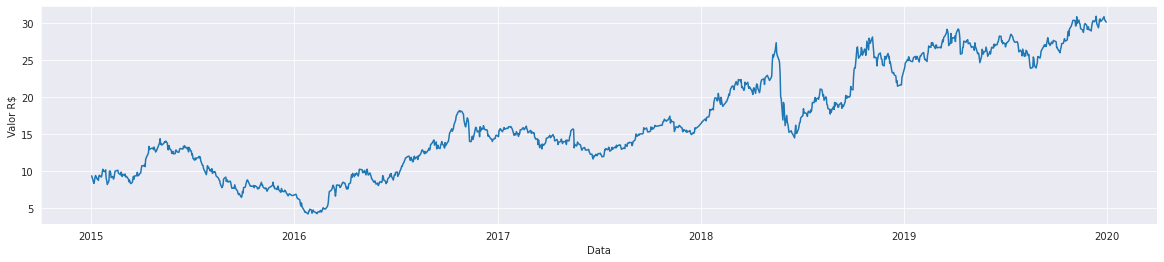

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(spot['S'])
ax.set_ylabel('Valor R$')
ax.set_xlabel('Data')
plt.show()

## Options

In [ ]:
# Dict to rename the columns
dict_ref = {
    'DATPRG': 'date',
    'CODNEG': 'option',
    'PREULT': 'value',
    'PREEXE': 'X',
    'DATVEN': 'expire',
    'TPMERC': 'option_type'
}

# Rename the columns
option = raw_data.rename(columns=dict_ref)

# Filter
option = option[option['option_type'].isin([70, 80])]
option = option[option['option'].str.startswith('PETR')]
option = option[dict_ref.values()]

# Dict symbol type
TPMERC = {70: 'call', 80: 'put'}

# Replace types
option['option_type'] = option['option_type'].replace(TPMERC)

workday = pd.DataFrame({'day': option['date'].unique()})
workday['day'] = pd.to_datetime(workday['day'])
workday = workday.sort_values(by='day')

# Create T
T = list()

for index, row in option.iterrows():
    T.append(workday[(workday['day'] >= row.date) & (workday['day'] <= row.expire)].shape[0] - 1)

option['T'] = T
option['T'] = option['T'] / 252

# Format and subset date
option['date'] = pd.to_datetime(option['date'])
option['expire'] = pd.to_datetime(option['expire'])
option = option.sort_values(by='date')

# Filter dates
option = option[(option['date'] < '01-01-2020') &
                (option['expire'] > '2015-01-19') &
                (option['expire'] <= '2019-12-16')]

option.index = option['date']
option = option.drop(['date'], axis=1)

option.head()

,option,value,X,expire,option_type,T
date,,,,,,
2015-01-02,PETRL44,0.50,17.00,2015-12-21,call,0.952381
2015-01-02,PETRF14,0.45,14.00,2015-06-15,call,0.436508
2015-01-02,PETRE14,0.41,14.00,2015-05-18,call,0.361111
2015-01-02,PETRE12,0.55,12.00,2015-05-18,call,0.361111
2015-01-02,PETRD78,0.43,12.41,2015-04-20,call,0.289683


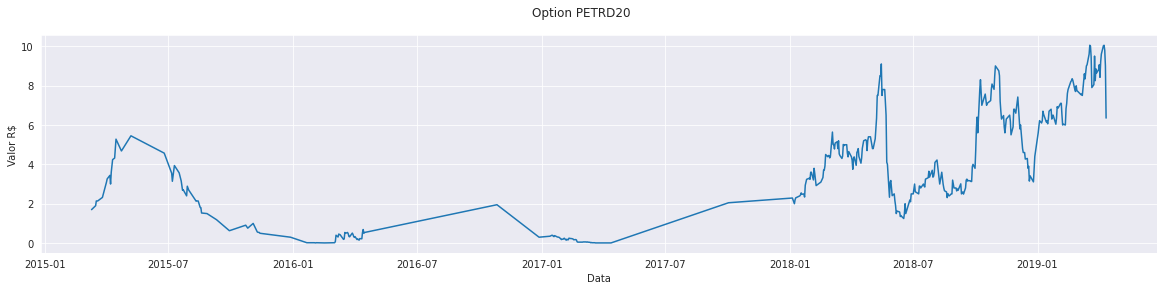

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('Option PETRD20')
ax.plot(option.loc[option['option'] == 'PETRD20', 'value'])
ax.set_ylabel('Valor R$')
ax.set_xlabel('Data')
plt.show()

## CDI

In [ ]:
cdi = pd.read_csv('/content/drive/My Drive/Datasets/cdi.csv', usecols=['date', 'cdi'])

# # Format and subset date
cdi['date'] = pd.to_datetime(cdi['date'], format='%d/%m/%y')
cdi = cdi.sort_values(by='date')

# Filter using the first date
cdi = cdi[cdi['date'].dt.month != cdi['date'].dt.month.shift(1)]

In [ ]:
# Create date range
date = pd.DataFrame({'date': pd.date_range(start='1/1/2015', end='12/31/2020')})

# Merge with cdi
date = date.merge(right=cdi, how='left', on='date')

# Fill Nan
date['cdi'] = date['cdi'].fillna(method='ffill')
cdi = date.dropna()

In [ ]:
# Create index
cdi = cdi.rename(columns={'cdi': 'r'})
cdi = cdi[cdi['date'] < '01-01-2020']
cdi.index = cdi['date']
cdi = cdi.drop(['date'], axis=1)
cdi.head()

,r
date,
2015-01-02,11.57
2015-01-03,11.57
2015-01-04,11.57
2015-01-05,11.57
2015-01-06,11.57


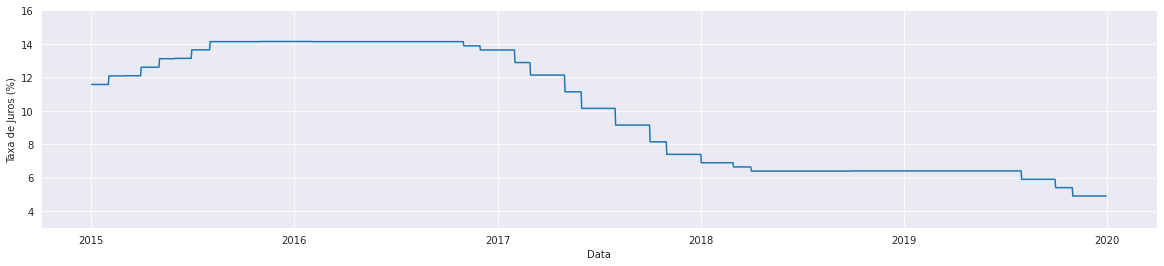

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(cdi)
ax.set_ylabel('Taxa de Juros (%)')
ax.set_ylim(3, 16)
ax.set_xlabel('Data')
plt.show()

## Data Merge

In [ ]:
# Merge data
data = option.merge(right=spot, right_index=True, left_index=True)
data = data.merge(right=cdi, right_index=True, left_index=True)
data.head()

,option,value,X,expire,option_type,T,S,volume,r
date,,,,,,,,,
2015-01-02,PETRL44,0.50,17.00,2015-12-21,call,0.952381,9.36,467547925.0,11.57
2015-01-02,PETRF14,0.45,14.00,2015-06-15,call,0.436508,9.36,467547925.0,11.57
2015-01-02,PETRE14,0.41,14.00,2015-05-18,call,0.361111,9.36,467547925.0,11.57
2015-01-02,PETRE12,0.55,12.00,2015-05-18,call,0.361111,9.36,467547925.0,11.57
2015-01-02,PETRD78,0.43,12.41,2015-04-20,call,0.289683,9.36,467547925.0,11.57


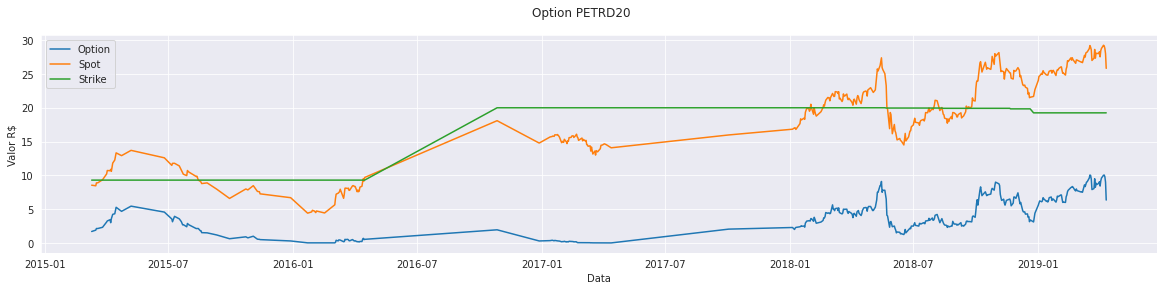

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('Option PETRD20')
ax.plot(data.loc[data['option'] == 'PETRD20', 'value'], label='Option')
ax.plot(data.loc[data['option'] == 'PETRD20', 'S'], label='Spot')
ax.plot(data.loc[data['option'] == 'PETRD20', 'X'], label='Strike')
ax.set_ylabel('Valor R$')
ax.set_xlabel('Data')
ax.legend()
plt.show()

In [ ]:
data

,option,value,X,expire,option_type,T,S,volume,r
date,,,,,,,,,
2015-01-02,PETRL44,0.50,17.00,2015-12-21,call,0.952381,9.36,4.675479e+08,11.57
2015-01-02,PETRF14,0.45,14.00,2015-06-15,call,0.436508,9.36,4.675479e+08,11.57
2015-01-02,PETRE14,0.41,14.00,2015-05-18,call,0.361111,9.36,4.675479e+08,11.57
2015-01-02,PETRE12,0.55,12.00,2015-05-18,call,0.361111,9.36,4.675479e+08,11.57
2015-01-02,PETRD78,0.43,12.41,2015-04-20,call,0.289683,9.36,4.675479e+08,11.57
...,...,...,...,...,...,...,...,...,...
2019-12-13,PETRX347,4.35,34.31,2019-12-16,put,0.003968,29.98,3.172882e+09,4.90
2019-12-13,PETRX311,0.84,30.81,2019-12-16,put,0.003968,29.98,3.172882e+09,4.90
2019-12-13,PETRL347,0.01,34.31,2019-12-16,call,0.003968,29.98,3.172882e+09,4.90


# GARCH (1,1)

In [ ]:
!pip install arch

     |████████████████████████████████| 798kB 4.4MB/s 


## Returns
Retornos Diários = $\ln\left(\dfrac{S_{i}}{S_{i-1}}\right) \cong  \left(\dfrac{S_{i} - S_{i-1}}{S_{i-1}}\right)$ 


Variância =  $\sigma^{2}_{n} = \dfrac{1}{m} \sum^{m}_{i=1} u_{n}^2$

In [ ]:
spot['return'] = np.log(spot['S'] / spot['S'].shift(1))
spot = spot.dropna()
spot['var'] = spot['return']**2
spot.head()

,S,volume,return,var
date,,,,
2015-01-05,8.61,674783884.0,-0.083521,0.006976
2015-01-06,8.33,706839884.0,-0.033061,0.001093
2015-01-07,8.67,733268924.0,0.040005,0.001600
2015-01-08,9.18,754338635.0,0.057158,0.003267
2015-01-09,9.40,460371734.0,0.023682,0.000561


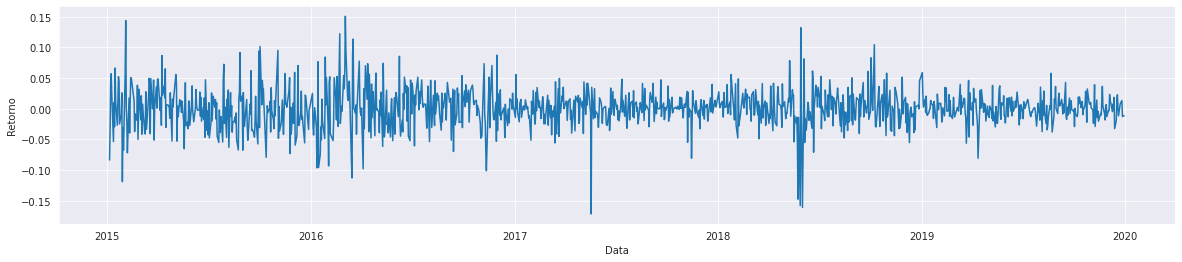

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(spot['return'])
ax.set_ylabel('Retorno')
ax.set_xlabel('Data')
plt.show()

## GARCH (with a Constant Mean)

In [ ]:
from arch import arch_model

am = arch_model(spot['return'], p=1, o=0, q=1)
res = am.fit(update_freq=5)
garch = res.conditional_volatility * math.sqrt(252) * 100
garch = garch.rename("sigma")
print(res.summary())

Iteration:      5,   Func. Count:     48,   Neg. LLF: -2637.187948724134
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2637.1967668680472
            Iterations: 8
            Function evaluations: 82
            Gradient evaluations: 8
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                2637.20
Distribution:                  Normal   AIC:                          -5266.39
Method:            Maximum Likelihood   BIC:                          -5245.92
                                        No. Observations:                 1233
Date:                Mon, Jul 13 2020   Df Residuals:                     1229
Time:                        00:27:58   Df Model:                            4
      

### Plot

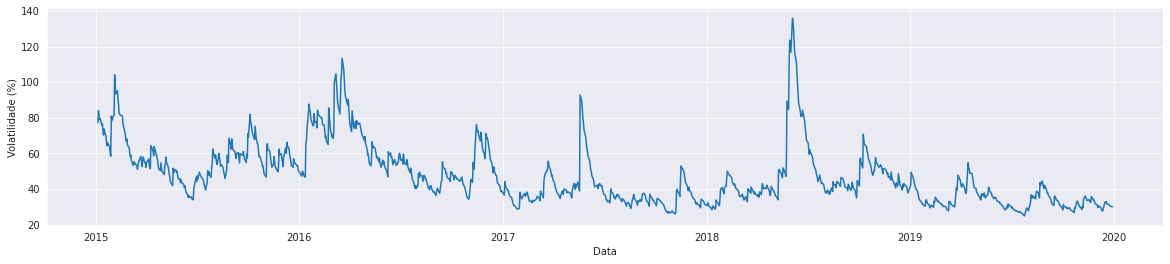

In [ ]:
fig, axs = plt.subplots(figsize=(20, 4))
axs.plot(garch)
axs.set_ylabel('Volatilidade (%)')
axs.set_xlabel('Data')
plt.show()

In [ ]:
data = data.merge(right=garch, right_index=True, left_index=True)
data = data.rename(columns={'cond_vol': 'vol'})
data.head()

,option,value,X,expire,option_type,T,S,volume,r,sigma
date,,,,,,,,,,
2015-01-05,PETRC53,0.65,9.61,2015-03-16,call,0.190476,8.61,674783884.0,11.57,77.182444
2015-01-05,PETRC50,0.90,9.01,2015-03-16,call,0.190476,8.61,674783884.0,11.57,77.182444
2015-01-05,PETRC51,0.81,9.21,2015-03-16,call,0.190476,8.61,674783884.0,11.57,77.182444
2015-01-05,PETRC52,0.73,9.41,2015-03-16,call,0.190476,8.61,674783884.0,11.57,77.182444
2015-01-05,PETRC54,0.61,9.81,2015-03-16,call,0.190476,8.61,674783884.0,11.57,77.182444


In [ ]:
cols = ['option', 'S', 'X', 'T', 'r', 'sigma', 'option_type', 'value']
data.to_csv('/content/drive/My Drive/Datasets/data_option.csv')

In [ ]:
data[data['option_type'] == 'put']

,option,value,X,expire,option_type,T,S,volume,r,sigma
date,,,,,,,,,,
2015-01-05,PETRO51,1.14,9.21,2015-03-16,put,0.190476,8.61,6.747839e+08,11.57,77.182444
2015-01-05,PETRN65,6.80,15.66,2015-02-09,put,0.099206,8.61,6.747839e+08,11.57,77.182444
2015-01-05,PETRN67,0.96,9.11,2015-02-09,put,0.099206,8.61,6.747839e+08,11.57,77.182444
2015-01-05,PETRN68,0.85,8.91,2015-02-09,put,0.099206,8.61,6.747839e+08,11.57,77.182444
2015-01-05,PETRN70,2.10,10.66,2015-02-09,put,0.099206,8.61,6.747839e+08,11.57,77.182444
...,...,...,...,...,...,...,...,...,...,...
2019-12-13,PETRX265,0.01,26.06,2019-12-16,put,0.003968,29.98,3.172882e+09,4.90,28.228712
2019-12-13,PETRX347,4.35,34.31,2019-12-16,put,0.003968,29.98,3.172882e+09,4.90,28.228712
2019-12-13,PETRX311,0.84,30.81,2019-12-16,put,0.003968,29.98,3.172882e+09,4.90,28.228712
